# Max Ensemble Low FPR

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

COLUMNWIDTH = 241.14749
COLUMNWIDTH_INCH = 0.01384 * COLUMNWIDTH
TEXTWIDTH = 506.295
TEXTWIDTH_INCH = 0.01384 * TEXTWIDTH

plt.style.use('seaborn-v0_8-paper')
# set fontsize
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('font', size=7)       
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=8)

mia_name_mapping = {"losstraj": "losstraj", "shokri": "Class-NN", "yeom": "LOSS", "lira": "LIRA", "aug": "aug", "calibration": "calibrated-loss", "reference": "reference"}
mia_color_mapping = {"losstraj": '#1f77b4', "shokri": '#ff7f0e', "yeom": '#2ca02c', "lira": '#d62728', "aug": '#9467bd', "calibration": '#8c564b', "reference": '#e377c2'}


1. Read the dataset

In [2]:
import os
import torch
import numpy as np
import pickle
from typing import List, Tuple, Dict

import sys
sys.path.append("../../../")
sys.path.append("../../")
sys.path.append("../")
from utils import ExperiementSet, TargetDataset
from miae.eval_methods.prediction import Predictions

datasets = ["cifar10", "cifar100", "cinic10"]
model = "resnet56"
output_dir = "/data/public/comp_mia_data/miae_experiment_aug_more_target_data/ensemble_at_low_FPR"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

target_datasets = []
for ds in datasets:
    target_datasets.append(TargetDataset.from_dir(ds, f"/data/public/comp_mia_data/miae_experiment_aug_more_target_data/target/{ds}"))


2. load the shadow attacks predictions and regular attack predictions

In [3]:
# note that the name 'obtain_shadow_roc' is misleading, it actually computes the ROC for every set of prediction + ground truth data

seeds = [0, 1, 2, 3, 4, 5]
fpr = 0.01
attack_list = ["losstraj", "lira", "calibration", "reference"] # these 4 attack has gained their precision for ensemble
pred_path = "/data/public/comp_mia_data/miae_experiment_aug_more_target_data"


    
experiement_dict = {}
for ds in target_datasets:
    experiement_dict[ds.dataset_name] = ExperiementSet.from_dir(ds, attack_list, pred_path, seeds, model, fpr_to_adjust=fpr)

3. calculate precision for single-instance, multi-instance, and ensemble. All at FPR = 0.01

In [4]:
import itertools
"""-------------- Single instance ----------------"""
single_instance_precision_dict = dict()
single_instance_pred_dict = dict()
for ds in target_datasets:
    single_instance_precision_dict[ds.dataset_name] = dict()
    single_instance_pred_dict[ds.dataset_name] = dict()
    for attack in attack_list:
        current_attack_pred = experiement_dict[ds.dataset_name].retrive_preds(attack, 0)
        single_instance_pred_dict[ds.dataset_name][attack] = current_attack_pred
        single_instance_precision_dict[ds.dataset_name][attack] = current_attack_pred.confusion_matrix_precision()

"""-------------- Multi instances ----------------"""
def prediction_intersection(prediction_list: List[Predictions]):
    """
    finds the intersection of hard_label predictions
    """
    pred_arr_list = [pred.pred_arr for pred in prediction_list]

    intersection_pred = np.ones_like(pred_arr_list[0])
    for arr in pred_arr_list:
        intersection_pred = np.logical_and(intersection_pred, arr)
    
    return Predictions(intersection_pred, prediction_list[0].ground_truth_arr, f"intersection_pred_{prediction_list[0].name}")

multi_instance_precision_dict = dict()
multi_instance_pred_dict = dict() # we will re-use the intersected pred later
for ds in target_datasets:
    multi_instance_precision_dict[ds.dataset_name] = dict()
    multi_instance_pred_dict[ds.dataset_name] = dict()
    for attack in attack_list:
        # retrieve predictions from all the instances
        multi_seed_list = [experiement_dict[ds.dataset_name].retrive_preds(attack, seed) for seed in seeds]
        # find intersection
        intersection_pred = prediction_intersection(multi_seed_list)
        multi_instance_pred_dict[ds.dataset_name][attack] = intersection_pred
        multi_instance_precision_dict[ds.dataset_name][attack] = intersection_pred.confusion_matrix_precision()
        

"""-------------- Multi-attack Ensemble----------------"""
def max_ensemble(pred_dict: Dict[str, Predictions], gt, attack_name_list) -> List[Predictions]:
    """
    Max ensemble predictions for all attack combinations.
    """

    def find_combinations_index(num_elements: int):
        """
        Find the list of all combinations of indices, including non-consecutive combinations.
        """
        lst = list(range(num_elements))
        combinations = []
        
        # Use itertools to generate all combinations of all lengths
        for r in range(2, num_elements + 1): 
            combinations.extend(itertools.combinations(lst, r))
        
        return [list(comb) for comb in combinations]
        

    combination_idx_list = find_combinations_index(len(pred_dict.keys()))
    
    result_pred_list = []
    for comb_idx in combination_idx_list:
        pred_union = np.zeros_like(pred_dict[attack_name_list[0]].pred_arr)
        attack_name_union = []
        for idx in comb_idx: # Do "OR" operation to find the union incrementally
            attack_name_union.append(attack_name_list[idx])
            pred_union = np.logical_or(pred_union, pred_dict[attack_name_list[idx]].pred_arr)
        result_pred_name = "_".join(sorted(attack_name_union)) + "max-ensemble"
        result_pred_list.append(Predictions(pred_union, gt, result_pred_name))
    return result_pred_list
 
multi_attack_ensemble_precision_dict = dict()
multi_attack_pred_dict = dict()

for ds in target_datasets:
    gt = ds.membership
    ensemble_predictions = max_ensemble(multi_instance_pred_dict[ds.dataset_name], gt, attack_list)
    multi_attack_pred_dict[ds.dataset_name] = dict()
    multi_attack_ensemble_precision_dict[ds.dataset_name] = dict()
    for pred in ensemble_predictions:
        multi_attack_pred_dict[ds.dataset_name][pred.name] = pred
        multi_attack_ensemble_precision_dict[ds.dataset_name][pred.name] = pred.confusion_matrix_precision()


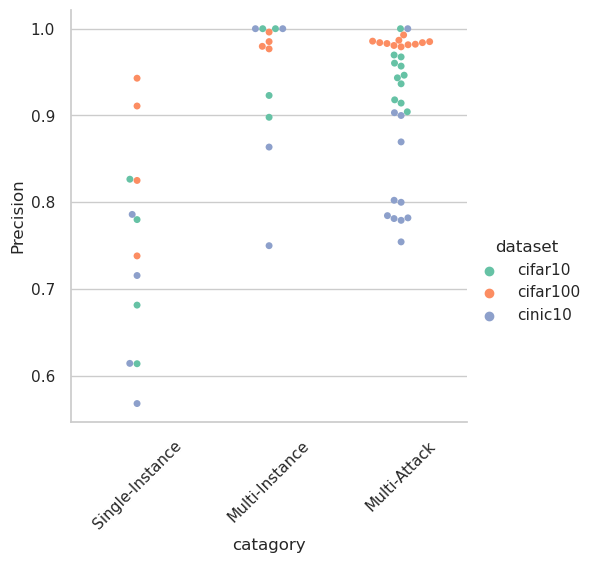

In [5]:
# plot precision with catagorical scatter plot
import seaborn as sns
import pandas as pd

def catagoical_scatter_plot(data: List[List[Dict[str, float]]], x_labels: List[str], 
                            ds: List, save_dir: str):
    """
    plot a catagorical scatter plot with hue as the ensemble level

    data: a list of precision dict
    x_labels: the x-axis labels (as catagories)
    ds: the dataset of the experiement
    save_dir: the directory to save the plot
    """
    assert len(data) == len(x_labels) # each label should have a corresponding dict

    x = []
    y = []
    ds_hue = []
    for ds_idx in range(len(ds)):
        for i, precision_dict in enumerate(data[ds_idx]):
            for _, precision in precision_dict.items():
                x.append(x_labels[i])
                y.append(precision)
                ds_hue.append(ds[ds_idx])

    df = pd.DataFrame({"catagory": x, "Precision": y, "dataset": ds_hue})
    sns.set_theme(style="whitegrid")
    ax = sns.catplot(x="catagory", y="Precision", kind="swarm", hue="dataset", palette="Set2", data=df)
    ax.set_xticklabels(rotation=45)
    plt.savefig(save_dir, dpi=300, bbox_inches='tight')

# plot the precision for each dataset
data_to_plot = []
for ds in datasets:
    data_to_plot.append([single_instance_precision_dict[ds], multi_instance_precision_dict[ds], multi_attack_ensemble_precision_dict[ds]])
    
x_labels = ["Single-Instance", "Multi-Instance", "Multi-Attack"]
save_dir = os.path.join(output_dir, f"precision_catagorical_scatter.pdf")
catagoical_scatter_plot(data_to_plot, x_labels, datasets, save_dir)

4. A spread sheet to compare the results

In [6]:
import pandas as pd


list_of_stats = []
ensemble_type = ["single_instance", "multi_instance", "multi_attack"]
keys_to_save = ["attack name", "ensemble_type", "dataset", "precision", "num_tp", "tpr", "fpr", "accuracy"]
for ds in datasets:
    for type_idx, pred_dict in enumerate([single_instance_pred_dict, multi_instance_pred_dict, multi_attack_pred_dict]):
        for attack_name, pred in pred_dict[ds].items():
            ensemble_type_name = ensemble_type[type_idx]
            precision = pred.confusion_matrix_precision()
            tpr = pred.compute_tpr()
            fpr = pred.compute_fpr()
            num_tp = len(pred.get_tp())
            accuracy = pred.accuracy()
            stat = zip(keys_to_save, [attack_name, ensemble_type_name, ds, precision, num_tp, tpr, fpr, accuracy])
            list_of_stats.append(dict(stat))

df = pd.DataFrame(list_of_stats)
df.to_csv(os.path.join(output_dir, "ensemble_stats.csv"), index=False)

In [7]:
# sub csv for each dataset
for ds in datasets:
    print()
    print(ds, ":")
    curr_data = df[df["dataset"] == ds]
    for ensemble_type in ["single_instance", "multi_instance", "multi_attack"]:
        print(ensemble_type, ":")
        curr_data_type = curr_data[curr_data["ensemble_type"] == ensemble_type]
        print("tpr \t fpr \t precision \t num_tp")
        for idx, row in curr_data_type.iterrows():
            print(format(row["tpr"], ".2e"), "\t", 
                  format(row["fpr"], ".2e"), "\t",
                  format(row["precision"], ".2f"), "\t", 
                  format(row["num_tp"]), "\t", row["attack name"])
    


cifar10 :
single_instance :
tpr 	 fpr 	 precision 	 num_tp
4.77e-02 	 1.00e-02 	 0.83 	 715 	 losstraj
1.58e-02 	 9.93e-03 	 0.61 	 237 	 lira
2.14e-02 	 1.00e-02 	 0.68 	 321 	 calibration
3.55e-02 	 1.00e-02 	 0.78 	 532 	 reference
multi_instance :
tpr 	 fpr 	 precision 	 num_tp
5.00e-03 	 0.00e+00 	 1.00 	 75 	 losstraj
3.20e-03 	 2.67e-04 	 0.92 	 48 	 lira
8.67e-04 	 0.00e+00 	 1.00 	 13 	 calibration
2.93e-03 	 3.33e-04 	 0.90 	 44 	 reference
multi_attack :
tpr 	 fpr 	 precision 	 num_tp
7.93e-03 	 2.67e-04 	 0.97 	 119 	 lira_losstrajmax-ensemble
5.67e-03 	 0.00e+00 	 1.00 	 85 	 calibration_losstrajmax-ensemble
7.40e-03 	 3.33e-04 	 0.96 	 111 	 losstraj_referencemax-ensemble
3.93e-03 	 2.67e-04 	 0.94 	 59 	 calibration_liramax-ensemble
5.67e-03 	 6.00e-04 	 0.90 	 85 	 lira_referencemax-ensemble
3.73e-03 	 3.33e-04 	 0.92 	 56 	 calibration_referencemax-ensemble
8.53e-03 	 2.67e-04 	 0.97 	 128 	 calibration_lira_losstrajmax-ensemble
1.00e-02 	 6.00e-04 	 0.94 	 150 	 lira

In [8]:
# prepare a csv for the table
table_path = os.path.join(output_dir, "building_latex_table")
if not os.path.exists(table_path):
    os.makedirs(table_path)
colums_to_save = ["method", "calibration", "reference", "lira", "losstraj", "cifar10TPR", "cifar100TPR", "cifar10FPR", "cifar100FPR", "cifar10Precision", "cifar100Precision", "cifar10NumTP", "cifar100NumTP"]
attack_for_csv = colums_to_save[1:5]

# new dictionary to build the new csv
def get_key(method, attack_table):
    """all inputs are string to format a key"""
    calibration, reference, lira, losstraj = attack_table
    return method + calibration + reference + lira + losstraj

def extract_attacks(string, attack_list):
    ret_list = []
    for a in attack_list:
        ret_list.append(str(a in string))
    return ret_list    

csv_dict = {}
csv_list = [] # each element is a row for the csv

for ds in ["cifar10", "cifar100"]:
    curr_data = df[df["dataset"] == ds]
    for ensemble_type in ["single_instance", "multi_instance", "multi_attack"]:
        curr_data_type = curr_data[curr_data["ensemble_type"] == ensemble_type]
        for idx, row in curr_data_type.iterrows(): 
            key = get_key(ensemble_type, extract_attacks(row["attack name"], attack_for_csv))
            if ds == "cifar10":
                csv_dict[key] = [None]*len(colums_to_save)
                csv_dict[key][0] = ensemble_type
                csv_dict[key][1], csv_dict[key][2], csv_dict[key][3], csv_dict[key][4] = extract_attacks(row["attack name"], attack_for_csv)
                csv_dict[key][5] = format(row["tpr"]*100, ".2f")
                csv_dict[key][7] = format(row["fpr"], ".2e")
                csv_dict[key][9] = format(row["precision"]*100, ".2f")
                csv_dict[key][11] = str(row["num_tp"])
            else:
                csv_dict[key][6] = format(row["tpr"]*100, ".2f")
                csv_dict[key][8] = format(row["fpr"], ".2e")
                csv_dict[key][10] = format(row["precision"]*100, ".2f")
                csv_dict[key][12] = str(row["num_tp"])
                # by now the row is complete, we can add it to the csv_dict
                csv_list.append(csv_dict[key])

# write the csv
fn = os.path.join(table_path, "ensemble_table.csv")
with open(fn, "w") as f:
    f.write(",".join(colums_to_save) + "\n")
    for row in csv_list:
        f.write(",".join(row) + "\n")

# write the latex table
fn = os.path.join(table_path, "ensemble_table.txt")
string_builder = ""
for row in csv_list:
    if row[0] == "single_instance":
        string_builder += "Single-instance"
    elif row[0] == "multi_instance":
        string_builder += "Multi-instance"
    else:
        string_builder += "Multi-attack"
    string_builder += "&\CIRCLE" if row[1] == "True" else "&\Circle" # calibration
    string_builder += "&\CIRCLE" if row[2] == "True" else "&\Circle" # reference
    string_builder += "&\CIRCLE" if row[3] == "True" else "&\Circle" # lira
    string_builder += "&\CIRCLE" if row[4] == "True" else "&\Circle" # losstraj
    for i in range(5, len(row)-2):
        string_builder += " & " + row[i] + "\%" if i in [5, 6, 9, 10] else " & " + row[i]
    for i in range(len(row)-2, len(row)):
        string_builder += " & " + row[i]
    string_builder += " \\\\\n"
with open(fn, "w") as f:
    f.write(string_builder)